In [1]:
import onnx

ImportError: DLL load failed while importing onnx_cpp2py_export: A dynamic link library (DLL) initialization routine failed.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from torchvision import datasets, transforms
import torchvision.transforms.functional as TF

# import onnx

import matplotlib.pyplot as plt

from PIL import Image

import numpy as np

import random

In [2]:
class RemoveBorder(object):
    def __init__(self, border_size=0):
        self.border_size = border_size

    def __call__(self, image):
        image = np.array(image)
        cropped_image = image[self.border_size:-self.border_size, self.border_size:-self.border_size]
        return cropped_image
    
class MaskCorners(object):
    def __init__(self):
        pass

    def __call__(self, image):
        image[0, 0] = 0
        image[0, -1] = 0
        image[-1, 0] = 0
        image[-1, -1] = 0

        return image

class DimReduce(object):
    def __init__(self, dim=0, lossy=True):
        self.dim = dim
        self.lossy = lossy

    def __call__(self, image):
        unfold = torch.nn.Unfold(kernel_size=(self.dim, self.dim), stride=self.dim, padding=0)
        patches = unfold(image)

        patches = patches.view(1, self.dim, self.dim, -1)

        num_patches = patches.shape[-1]
        patches = patches.permute(3, 1, 2, 0).squeeze(-1)

        if self.lossy:
            patch_sums = patches.sum(dim=(1, 2))
        else:
            patch_sums = []
            for i in range(num_patches):
                patch = patches[i]
                patch_sum = 0
                for i, row in enumerate(patch):
                    for j, value in enumerate(row):
                        patch_sum += ((i+j) << value)
                patch_sums.append(patch_sum)
            patch_sums = torch.tensor(patch_sums)

        # # figure out the correct way to calculate this
        s = 5 # 2x2
        # s = 3 # 3x3
        # s = patches.shape[0] // patches.shape[1]
        return patch_sums.reshape((s,s)).float()
            

In [3]:
import random
import torchvision.transforms.functional as TF

class RandomShiftRotateZoom:
    def __init__(self, max_shift=1, max_rotate=5, zoom_out_prob=0.5, max_zoom_out=0.8):
        self.max_shift = max_shift
        self.max_rotate = max_rotate
        self.zoom_out_prob = zoom_out_prob
        self.max_zoom_out = max_zoom_out 

    def __call__(self, img, idx=None):
        rng = random.Random(42 + (idx if idx is not None else 0))

        dx = rng.randint(-self.max_shift, self.max_shift)
        dy = rng.randint(-self.max_shift, self.max_shift)

        angle = rng.uniform(-self.max_rotate, self.max_rotate)

        scale = 1.0
        if rng.random() < self.zoom_out_prob:
            scale = rng.uniform(self.max_zoom_out, 1.0)

        img = TF.affine(img, angle=angle, translate=(dx, dy), scale=scale, shear=0)

        return img

In [4]:
class DuplicatedAugmentedDataset(Dataset):
    def __init__(self, base_dataset, augment_transform):
        self.base_dataset = base_dataset
        self.augment_transform = augment_transform
        self.original_len = len(base_dataset)

    def __len__(self):
        return self.original_len * 2

    def __getitem__(self, idx):
        base_idx = idx % self.original_len
        img, label = self.base_dataset[base_idx]

        if idx >= self.original_len:
            if hasattr(self.base_dataset, 'data') and hasattr(self.base_dataset, 'targets'):
                raw_img = self.base_dataset.data[base_idx]
                raw_img = transforms.ToPILImage()(raw_img)
                img = self.augment_transform(raw_img)
            else:
                img = self.augment_transform(img)

        return img, label


In [5]:
augmented_training = False
dim = 2
lossy=True
transform = transforms.Compose([
    transforms.Resize((16, 16)),
    RemoveBorder(border_size=3),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.2)),
    # MaskCorners(),
    DimReduce(dim=dim, lossy=lossy),
])

augment_transform = transforms.Compose([
    RandomShiftRotateZoom(max_shift=3, max_rotate=10, zoom_out_prob=0.3, max_zoom_out=0.8),
    transforms.Resize((16, 16)),
    RemoveBorder(border_size=3),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.2)),
    DimReduce(dim=dim, lossy=lossy),
])

if augmented_training:
    base_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    train_dataset = DuplicatedAugmentedDataset(base_train_dataset, augment_transform)
else:
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform) 
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)


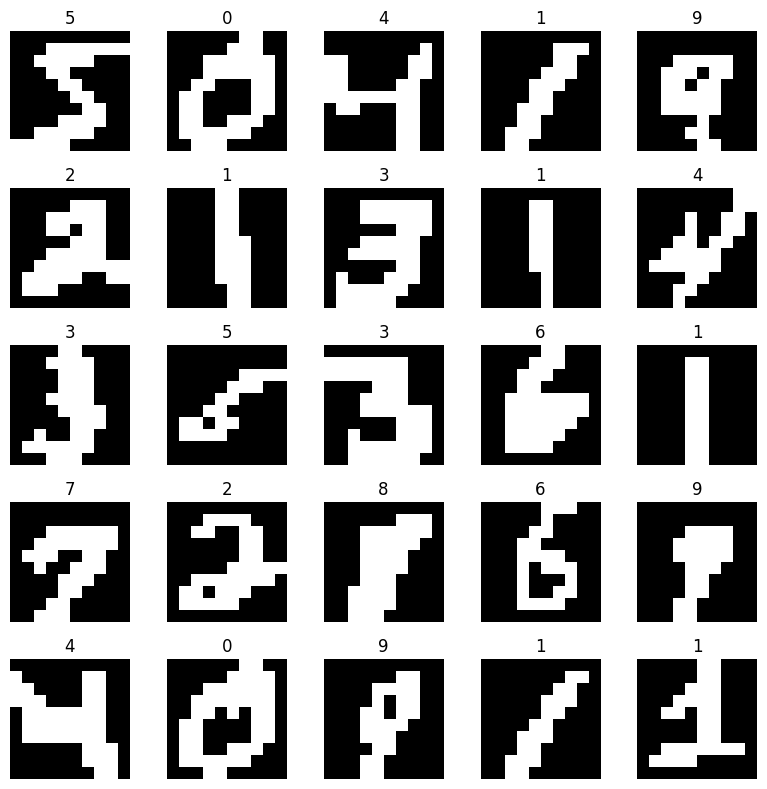

In [6]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    # RemoveBorder(border_size=3),
    RemoveBorder(border_size=3),
    transforms.Lambda(lambda x: Image.fromarray(x)),
    transforms.Resize((10, 10)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.2)),
    # DimReduce(dim=dim, lossy=lossy),
])


raw_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

fig, axes = plt.subplots(5, 5, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    image, label = raw_dataset[i]
    image = image.squeeze(0).numpy()

    ax.imshow(image, cmap='gray')
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()
plt.show()

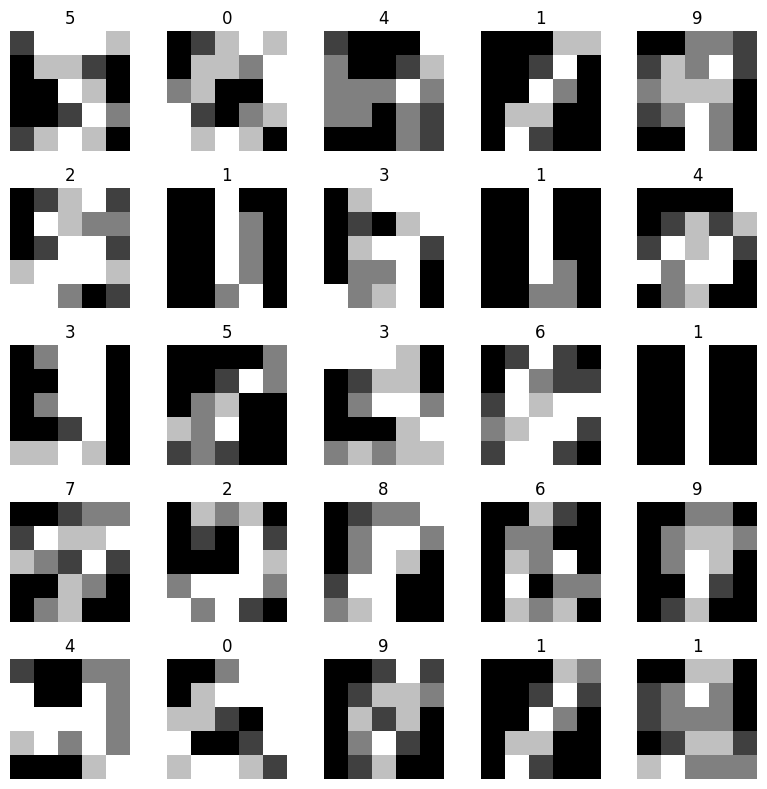

In [7]:
fig, axes = plt.subplots(5, 5, figsize=(8, 8))

for i, ax in enumerate(axes.flat):
    image, label = train_dataset[i]
    image = image.squeeze(0).numpy()

    ax.imshow(image, cmap='gray')
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()
plt.show()

[[1. 4. 4. 4. 3.]
 [0. 3. 3. 1. 0.]
 [0. 0. 4. 3. 0.]
 [0. 0. 1. 4. 2.]
 [1. 3. 4. 3. 0.]]


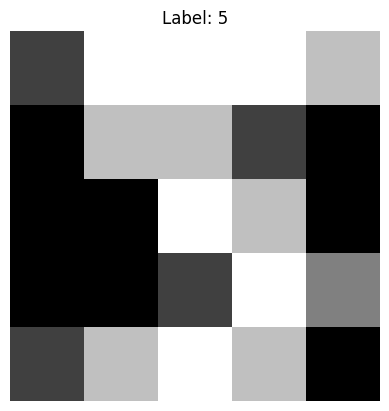

In [8]:
image, label = train_dataset[0]
image_np = image.squeeze(0).numpy()

print(image_np)
plt.imshow(image_np, cmap='gray')
plt.title(f"Label: {label}")
plt.axis('off')
plt.show()

In [9]:
use_bias = False
# bottleneck = 64
# bottleneck = 32
# bottleneck = 16
bottleneck1 = 20
bottleneck2 = 15
# bottleneck = 8
# bottleneck = 5
class SimpleNN(nn.Module):
    def __init__(self, res):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(res * res, bottleneck1, bias=use_bias)
        self.fc2 = nn.Linear(bottleneck1, bottleneck2, bias=use_bias)
        self.fc3 = nn.Linear(bottleneck2, 10, bias=use_bias)
        self.relu = nn.ReLU()

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                
    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [10]:
print(f'resolution: {train_dataset[0][0].shape[1]}')
model = SimpleNN(train_dataset[0][0].shape[1])
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

resolution: 5


In [11]:
print(model)

SimpleNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=25, out_features=20, bias=False)
  (fc2): Linear(in_features=20, out_features=15, bias=False)
  (fc3): Linear(in_features=15, out_features=10, bias=False)
  (relu): ReLU()
)


In [ ]:
# for training a already existing model longer
# model.load_state_dict(torch.load('mnist_2x2_5_20_15_True_10e_False.model'))

In [11]:
num_epochs = 8
# num_epochs = 10
# num_epochs = 15
# num_epochs = 20
# num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/8, Loss: 1.1373
Epoch 2/8, Loss: 0.6285
Epoch 3/8, Loss: 0.5243
Epoch 4/8, Loss: 0.4827
Epoch 5/8, Loss: 0.4608
Epoch 6/8, Loss: 0.4472
Epoch 7/8, Loss: 0.4360
Epoch 8/8, Loss: 0.4276


In [12]:
def get_num_layers(model):
  num_layers = 0
  for _ in model.named_children():
    num_layers += 1
  return num_layers
# filename = f'mnist_{dim}x{dim}_{get_num_layers(model)}_{bottleneck1}_{bottleneck2}_{lossy}_{num_epochs}e_{use_bias}_{augmented_training}.model'
filename = 'BEST2_mnist_2x2_5_20_15_True_30e_False_False.model'
print(f'using: {filename}') 

using: BEST2_mnist_2x2_5_20_15_True_30e_False_False.model


In [13]:
torch.save(model.state_dict(), filename)

In [13]:
# filename = 'mnist_2x2_5_20_15_True_10e_False_False.model'
# model = SimpleNN()
# model.load_state_dict(torch.load('mnist_3x3_notLossy.model'))
model.load_state_dict(torch.load(filename))

C:\Users\Kirin\AppData\Local\Temp\ipykernel_40052\2929716687.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(filename))


<All keys matched successfully>

In [14]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 92.42%


In [15]:
torch.onnx.export(
    model,
    torch.randn(1, 25),
    "model.onnx",
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    }
)

OnnxExporterError: Module onnx is not installed!

In [ ]:
import onnx

onnx_model = onnx.load("model.onnx")
onnx.checker.check_model(onnx_model)
print("Model is valid!")

In [99]:
import base64
import zlib
import json

In [100]:
def encode_string(s):
    return b'0' + base64.b64encode(zlib.compress(str.encode(s), level=9))
def decode_string(s):
    return zlib.decompress(base64.b64decode(s[1:]))

In [101]:
# print(model.fc1.weight.data * 1000)
# print(model.fc2.weight.data * 1000)
# print(model.fc3.weight.data * 1000)
print(torch.tensor(image_np).flatten())
res1 = torch.tensor(image_np).flatten() @ (model.fc1.weight.data * 1000).T
print(res1)
res2 = res1 @ (model.fc2.weight.data * 1000).T
res2 //= 100
print(res2)
res3 = res2 @ (model.fc3.weight.data * 1000).T
res3 //= 10
print(res3)
print(torch.argmax(res3))

tensor([1., 4., 4., 4., 3., 0., 3., 3., 1., 0., 0., 0., 4., 3., 0., 0., 0., 1.,
        4., 2., 1., 3., 4., 3., 0.])
tensor([-2789.2129,   479.6644,  1839.4395,  5152.7520,  6491.4185,  4922.3804,
          786.0377,  7949.2671,  1261.7543,  8634.4473, -2913.1248, -3398.6633,
        -2999.7200, 12744.8340,  1360.7495,  8038.9854, -7817.6235, -2419.0657,
        -4134.3271,  4266.1924])
tensor([ 96448., -26979., -34551., -91920., -48844., -17192.,  78394.,    255.,
         80141.,  64661.,  -1977., -62938., 110010., 104410.,  61762.])
tensor([   390611.,  -4118180., -14861280.,  10623572., -16567680.,   8410709.,
          1226951., -10946266.,  10737705.,  -6919720.])
tensor(8)


In [105]:
# export matrix as constant combinators in factorio blueprint

# arr = np.array([[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25],[25,24,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1]])
# arr = (model.fc1.weight.data * 1000).int()
# arr = (model.fc2.weight.data * 100).int()
arr = (model.fc3.weight.data * 10).int()

d = {"blueprint": {"icons": [{"signal": {"name": "constant-combinator"}, "index": 1}], "entities": [],"item": "blueprint","version": 562949956239363}}

curr_x = 103.5
curr_y = 240.5

for idx, sub in enumerate(arr):
    el = {"entity_number": 1, "name": "constant-combinator", "position": { "x": -1, "y": -1 }, "direction": 4, "control_behavior": {"sections": {"sections": [{"index": 1,"filters": []}]}}}

    el['entity_number'] = idx + 1
    el['position']['x'] = curr_x
    el['position']['y'] = curr_y
    curr_y += 1

    for i in range(0, len(sub)):
        sig= {"index": 1,"type": "virtual","name": "signal-","quality": "normal","comparator": "=","count": 0}

        sig['index'] = i + 1
        sig['name'] += chr(ord('A') + i)
        sig['count'] = f'{sub[i]}'

        el['control_behavior']['sections']['sections'][0]['filters'].append(sig)

    d['blueprint']['entities'].append(el)

# print(json.dumps(d, indent=2))
print(encode_string(json.dumps(d)))


b'0eNrtnNuOmzAQhl9lxfWysvEpVOpFz+fuA1SrFcnS1lICKSFRoxXvXkNWuw1pkQXkVzSKchGwjX/sIH+ZGQ/3wXS+TpeFzcrg2cV9YGd5tnJH3+6Dlf2RJfOmNEsWqTsI6soyycpwli+mNkvKvAiqy4vAZnfpb9eAVzfuLM1KW9r0oZvmbHubrRfTtKjbuBZd/bnqZb5yHeRZo930y8SVchVbdxxJdqVq0TtbpLOHZvKy6aws8vntNP2ZbGxeNFevdk1W7RN3Y4837a79budlWvyjotwumzvd2KJcu9n46+Z38xO+qMt+uTo3yro4y4vFrqEb1DIpmkG58ue7onUz0UEY1RP3pBV5ab3sp6X2tYSX1qtRxiW9tF730xL7WspL600vrdawtJfU21GGZby03vXSYvtSEy+p92NIxV5SH8b4sTjz0vo4xrC436Lxqd+TwVtifqvG51EeQ+63bHzpJ2ZaYn7rxtdxRua3cFz3EouD6sZ9qkaxzcJoMAs5BRYaHAsnOBQaIAljHAlDIAojkiRUOBKGGohCDkShQZLQIEkYAUnIgSCs/7z8n4RiMAkjCiTkDIdCAbQKFY6FEodCgSMh0CZsWxnHRKHGoZABSaiAJETahAwJQg0EoQSCsJODcjAHBQEOCpoU5ECL0OAwyIG+UQ7koMZxUJ6do0M5yIAc5EAOMiAGFdIejLo4qAZzUJ45eKIc5CSNwRBoDUogBQWOgiHQHDwIAlGxB5EcVEAOcmSEkCM9o6wLhHowCBUJxyhwuwwwRhhKoEmocTA0OBZymiwkul2m/cAfFYUCiMIIiELoZpkISELRRUIzmISaAgk1joQREIQCB0IGNAo5J2kVKqBRCPSNckZ0uwyjGiSUSBSaU4kSTgaj0BBAIXCvDDCDQpEEoaSZP9FeEo4JQoPjIHLXqEEmUAiiQcK2z+qoHGSngsF4MAYnZ9/oIG8AmVRCjkMhA6JQ4VCoSfpG2zNIxiKEohCaQcGIJ

In [55]:
# print(encode_string('{"blueprint": {"entities": [{"entity_number": 1, "name": "wooden-chest", "position": {"x": 1, "y": 1}}], "item": "blueprint"}}'))

# s = decode_string('0eNql1ltrgzAUB/Dvcp7T0nrpprCH3e/3O6MUbbMtoNHFWFqK330nyjq2hx2W4IN6kvw8Cn/MCtKs5qUSUkO8AjEtZAXxywoq8SaTzNRkknOIwYzoROretMhTIRNdKGgYCDnjC4iHzZgBl1powTugvVlOZJ2nXOEE9hfEoCwqXFtI80TjDfx+yGAJsRcM+iE+aCYUn3YzAmYQrYpskvL3ZC5QwGVVN179vMZWvnpk8CoyzdXvql6WprG5ULrGd1532n2D3jZWPnAAXweLslB5OwnbLxPVth/DVluozVf0GrbGPRLfscd9Et+1xwMS37PHQxLft8dHJH5gj2+Q+KE9vkniR/Z4ROLH9vhwQOonDjqd0VMHnQ7pmYNOp/TcQadjeuGg0zm9dNDpoF456HRSrx10Oqo3Djqd1VuHfxKd1TsHnc7qvYNOZ/XBQaez+uig01l9ctDprD7/Vx/j0ZiNndA8x8HvrSKDOW6j2s1YOPKiIIrw5Ef+yG+aT7p+Wd4=')
s = decode_string('0eNrt2FtrwjAYBuD/8l1noj24tbCLnc/nM0Ok1WwLtGmXpjKR/vclLXPMi30sgV0FL9QkfZIWXnxxAWlW01IwLiFeAJsUvIL4eQEVe+VJpsd4klOIQc/IhMu1SZGnjCeyENAQYHxKPyAeNCMClEsmGe2A9st8zOs8pUItIL9BBMqiUtcWXO+ovb7fCwnMIfb8qBeqjaZM0Em3IiAakaLIxil9S2ZMCeqyqpuvfn5WR/k6I4EXlkkqVkflvNQHmzEha3XPy5N2z2BtS428qwl1O2qQFyJvF6njl4lojx/DZjtQ66foNWSJeyi+bY77KL5jjgcovmuOhyi+Z44PUXzfHF9H8QNzfAPFD83xCMWPzPFBH9WPLXQ8oycWOh7SUwsdT+mZhY7H9NxCx3N6YaHjQb200PGkXlnoeFSvLXQ8qzcWv0l4Vm8tdDyrdxY6ntV7Cx3P6oOFjmf10ULHs/r0V32kXo3eY6XLecZdLui7Lue6nOtyrsu5Lue6nOtyrsu5LvefXW5EgEmaq8nvv/0IzFSNastYOPSiIIrUmx/5Q79pPgF0vIZK')
j = json.loads(s)
print(json.dumps(j, indent=2))

{
  "blueprint": {
    "icons": [
      {
        "signal": {
          "name": "constant-combinator"
        },
        "index": 1
      }
    ],
    "entities": [
      {
        "entity_number": 1,
        "name": "constant-combinator",
        "position": {
          "x": 103.5,
          "y": 239.5
        },
        "direction": 4,
        "control_behavior": {
          "sections": {
            "sections": [
              {
                "index": 1,
                "filters": [
                  {
                    "index": 1,
                    "type": "virtual",
                    "name": "signal-A",
                    "quality": "normal",
                    "comparator": "=",
                    "count": 2
                  },
                  {
                    "index": 2,
                    "type": "virtual",
                    "name": "signal-B",
                    "quality": "normal",
                    "comparator": "=",
                    "count": 2
  